In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import warnings
import spacy
import statsmodels.api as stats
import seaborn as sns
from scipy import stats
from pingouin import compute_effsize
from nlp_tools import VAD, VAD_analysis, text_processing, data_analysis, utilities
from nlp_tools import paragraph_level_vad as tools

warnings.filterwarnings("ignore")
pd.set_option('mode.copy_on_write', True)
rng = np.random.default_rng()
nlp = spacy.load("en_core_web_sm")

dataset = pd.read_csv("data/migrant-dehumanization.csv")
reference_table = pd.read_csv("data/migrant-dehumanization-codebook.csv")
dataset = utilities.process_dataset(dataset, reference_table)
dataset["article_idx"] = dataset.index

to_analyse = ["BBC", "Daily mail", "Metro"]

if not "corpus" in globals(): # this ensures this section only runs once. it takes approx 9 mins
    corpora = []
    unprocessed_corpora = []
    for name in to_analyse:
        series = text_processing.load_corpus(name)
        unprocessed_corpora.append(series)
        processed = text_processing.preprocess_corpus(series, keep_paragraphs=True, remove_stopwords=True, remove_punctuation=True)
        corpora.append(processed)
    corpus = pd.concat(corpora)
    unprocessed_corpus = pd.concat(unprocessed_corpora)

/Users/eddie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
## Set up data

target_group_words = ["migrant", "immigrant", "immigration", "refugee"]
control_group_words = ["briton", "british", "english", "britain"] # alternatives- family, parent, citizen, inhabitant, native, local, person, employee, people

def lexicon_coverage(sentence):
    count = 0
    for word in sentence:
        if word in VAD.index:
            count += 1
    return count/len(sentence)

if not "results" in globals(): # ensures this section of the code doesn't re-run
    results = tools.analyse(corpus, target_group_words)
    results["article_idx"] = tools.get_article_index(results, corpus)
    results = results.dropna() #results.drop("text_split", axis=1, inplace=True)

    results["coverage"] = results["text_split"].apply(lexicon_coverage)
    results["score"] = results["len"] * results["coverage"]

    target_group_results = results[results["score"] > 5]
    control_group_results = tools.analyse(corpus, control_group_words)

    run_analysis_permut = lambda wordlist: tools.analyse(corpus, wordlist)
    get_range = lambda data: data.max() - data.min()

## Run analyses

significance_level = 0.05
output = True
test_types = {"valence": "less"}
analysis_to_run = "mean std ttest cohens d"

if "mean" in analysis_to_run:
    compare_by_mean = tools.compare([target_group_results, control_group_results], names=["migrants", "controls"], return_comparison=False)
    print("Compare by mean:\n\t" + str(compare_by_mean).replace("\n", "\n\t") + "\n")

if "std" in analysis_to_run:
    compare_by_std = tools.compare([target_group_results, control_group_results], func=np.std, names=["migrants", "controls"], return_comparison=False)
    print("Compare by standard deviation:\n\t" + str(compare_by_std).replace("\n", "\n\t") + "\n")

if "ttest" in analysis_to_run:
    pvalues = []
    if output: print("Conducting t-test:")
    for var in test_types.keys():
        test = stats.ttest_ind(target_group_results[var], control_group_results[var], alternative=test_types[var], nan_policy="omit")
        pvalues.append(test.pvalue)
        diff = (control_group_results[var].mean() - target_group_results[var].mean()).round(3)

        if test.pvalue < significance_level:
            if output: print("\tThere is enough evidence to reject the null hypothesis for", var, "(p: {}, difference: {})".format(test.pvalue, diff))
            if output: print("\tt({}) = {}, p = {}".format(test.df, test.statistic, test.pvalue))
            if "cohens d" in analysis_to_run:
                cohensd = compute_effsize(target_group_results[var], control_group_results[var], eftype="cohen")
                print("\tCohen's d: {}\n".format(cohensd))
        else:
            if output: print("\tThere is insufficient evidence to reject the null hypothesis for", var, "(p: {}, difference: {})".format(test.pvalue, diff))
    if output: print()

if "permut" in analysis_to_run:
    if output: print("Conducting permutation test:")
    permut_results = data_analysis.permutation_test_difference(target_group_words, control_group_words, test_types, run_analysis_permut, n=1000, output=output, return_proportions=False)

Compare by mean:
	           migrants  controls
	valence    0.110834  0.186151
	arousal     0.00207 -0.034401
	dominance    0.0959   0.13507

Compare by standard deviation:
	           migrants  controls
	valence    0.149268  0.180354
	arousal    0.117734  0.132747
	dominance  0.103726  0.125719

Conducting t-test:
	There is enough evidence to reject the null hypothesis for valence (p: 2.22497140223344e-67, difference: 0.075)
	t(11405.0) = -17.417766178002346, p = 2.22497140223344e-67
	Cohen's d: -0.49045539388037007




M = 39.32236842105263, SD = 39.942923872641174


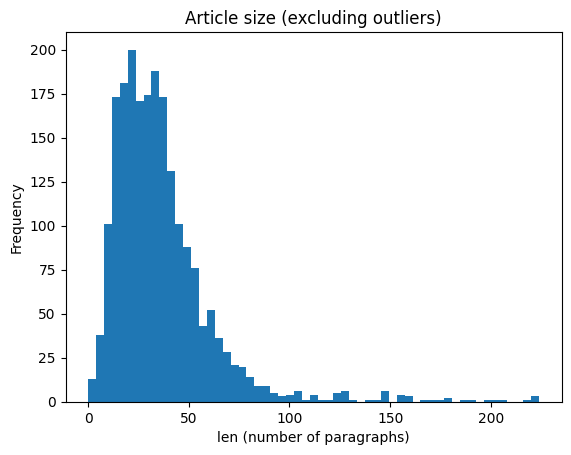

M = 12.501410167547025, SD = 9.471488147351666


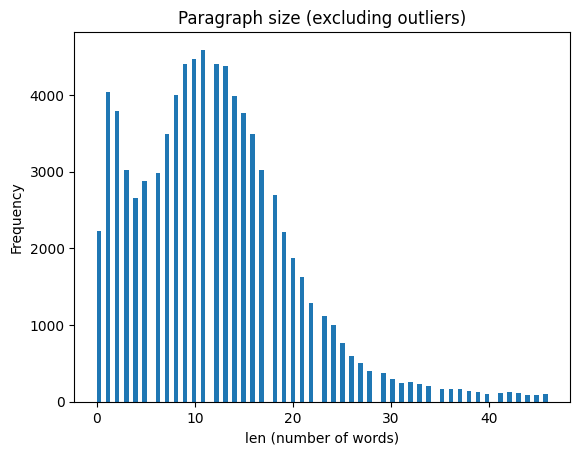

In [3]:
## Corpus descriptive statistics and diagnostic plots

article_len = corpus.apply(len)
paragraph_len = pd.Series(np.concatenate(corpus.apply(text_processing.apply_to_subset, function=len).values)) # or use results

to_plot = [article_len, paragraph_len]
exclude_outliers = True
titles = ["Article size (excluding outliers)", "Paragraph size (excluding outliers)"]
labels = ["len (number of paragraphs)", "len (number of words)"]
print_descriptive_stats = True

for i, data in enumerate(to_plot):
    if print_descriptive_stats:
        print("M = {}, SD = {}".format(data.mean(), data.std()))
    if exclude_outliers:
        data = data[data < data.quantile(0.99)]
    n_bins = int((data.max() - data.min()) / (2 * (data.quantile(0.75) - data.quantile(0.25)) / data.count()**(1/3)))  # Freedman-Diaconis rule
    data.plot(kind="hist", bins=n_bins)
    plt.xlabel(labels[i])
    plt.title(titles[i])
    plt.show()

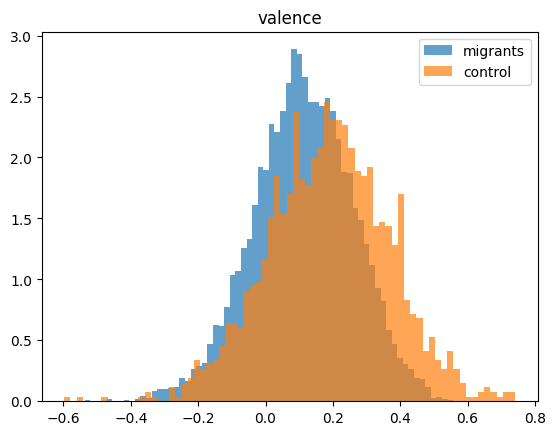

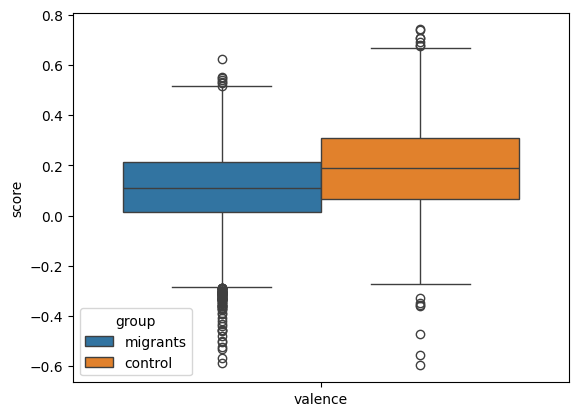

In [4]:
## Create data visualisations - histogram

alph = 0.7

for var in ["valence"]:
    data = pd.concat([target_group_results[var], control_group_results[var]])
    n_bins = int((data.max() - data.min()) / (2 * (data.quantile(0.75) - data.quantile(0.25)) / data.count()**(1/3)))  # Freedman-Diaconis rule
    plt.hist(target_group_results[var], bins=n_bins, density=True, alpha=alph)
    plt.hist(control_group_results[var], bins=n_bins, density=True, alpha=alph)
    plt.title(var)
    plt.legend(["migrants", "control"])
    plt.show()

## Boxplot

dfs = []
for var in ["valence"]:
    df = pd.DataFrame()
    temp = target_group_results.reset_index()
    df["migrants"] = temp[var]
    temp = control_group_results.reset_index()
    df["control"] = temp[var]
    df[""] = var
    dfs.append(df)

full = pd.concat(dfs)
fullmelted = full.melt(id_vars="", value_vars=["migrants", "control"], var_name="group", value_name="score")
sns.boxplot(x="", y="score", hue="group", data=fullmelted)
plt.show()

### Additional plots / functions

In [ ]:
## Code to get the data for my qual analysis

semiprocessed_corpus = corpus.apply(text_processing.apply_to_subset, function=" ".join)

def get_paragraph_idx(row):
    idx = semiprocessed_corpus.loc[row.name].index(row["text"])
    return idx

def get_sentence_in_context(row, paragraph_idx, size=1):
    idx = paragraph_idx.loc[row.name]
    size=int(size/2)
    if idx-size < 0:
        sizeL=0
    else:
        sizeL=size
    if idx+size >= len(row["data"]):
        sizeR = idx-size
    else:
        sizeR = size
    text = row["data"][idx]
    fulltext = row["data"][idx-sizeL:idx+sizeR+1]
    fulltext[fulltext.index(text)] = "*" + text + "*"
    return fulltext

def format_article(row, paragraph_idx, size, symbol=["**", "**"]):
    idx = paragraph_idx.loc[row.name]
    fulltext = row["data"]
    fulltext[idx] = symbol[0] + row["data"][idx] + symbol[1]
    return fulltext

def get_qual_data(df, var="valence", lowest=True, topn=5, context_size=5, export=True, exporttype="txt", output=False, _return=False, random=False, process_func=format_article, unprocessed_corpus=unprocessed_corpus):
    if not random:
        to_find = df.sort_values(by=var, ascending=lowest)[:topn]
    else:
        to_find = df.sample(topn)
    to_find.set_index("article_idx", drop=True, inplace=True)
    paragraph_idx = to_find.apply(get_paragraph_idx, axis=1)
    temp_df = pd.DataFrame()
    temp_df["data"] = unprocessed_corpus.apply(copy.deepcopy)
    data = temp_df.loc[to_find.index].apply(process_func, axis=1, paragraph_idx=paragraph_idx, size=context_size).values
    
    new = []
    for article in data:
        new.append("\n".join(article))
    text = "\n\n".join(new)

    if output:
        print(text)
    elif _return:
        return text
    if export:
        filename = "data/qual data/{}_{}.{}".format(var, ["highest", "lowest"][lowest], exporttype)
        with open(filename, "w") as file:
            file.write(text)

## version 1

if not os.path.exists("data/qual data/valence_lowest.md"):
    for var in VAD.columns:
        for low in [True,False]:
            get_qual_data(results, var, low, 5, export=True, exporttype="md")


## version 2

search = lambda sentence, word: word in sentence
idx = results[results["text"].apply(search, word="tide")]["article_idx"].values
dataset.loc[idx]["link"].apply(print);

,text,text_split,len,valence,arousal,dominance,coverage,score,time,frame,subframe,D/H,country,source,keyword
333.0,mr ozdag say agree plan send million migrant c...,"[mr, ozdag, say, agree, plan, send, million, m...",10,0.325500,-0.062875,0.158375,0.800000,8.0,2023-05-01,politicized,life goes on,0.0,syrian,BBC,"""Immigrant women"""
333.0,mr ozdag lead victory party say hold similar t...,"[mr, ozdag, lead, victory, party, say, hold, s...",17,0.314538,0.088846,0.201538,0.764706,13.0,2023-05-01,politicized,life goes on,0.0,syrian,BBC,"""Immigrant women"""
333.0,turkey host refugee world million syrian tempo...,"[turkey, host, refugee, world, million, syrian...",17,0.223692,-0.003385,-0.010692,0.764706,13.0,2023-05-01,politicized,life goes on,0.0,syrian,BBC,"""Immigrant women"""
333.0,run second round mr kilicdaroglu double pledge...,"[run, second, round, mr, kilicdaroglu, double,...",25,0.249944,0.010333,0.173611,0.720000,18.0,2023-05-01,politicized,life goes on,0.0,syrian,BBC,"""Immigrant women"""
333.0,mr ozdag say agree seven point plan opposition...,"[mr, ozdag, say, agree, seven, point, plan, op...",30,0.124963,-0.043185,0.082148,0.900000,27.0,2023-05-01,politicized,life goes on,0.0,syrian,BBC,"""Immigrant women"""


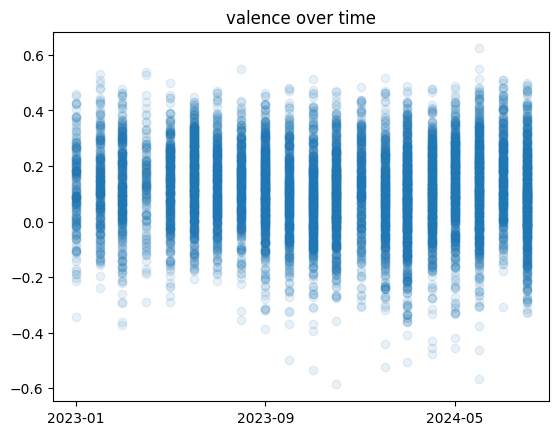

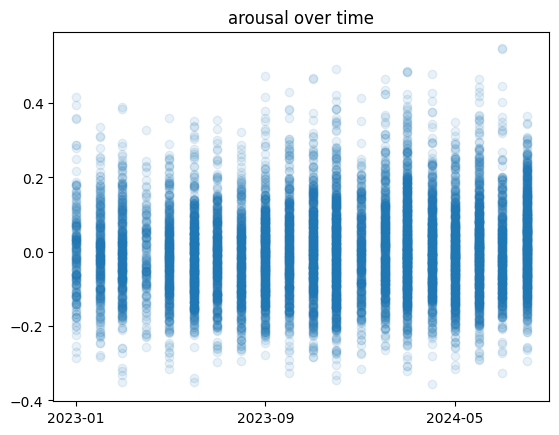

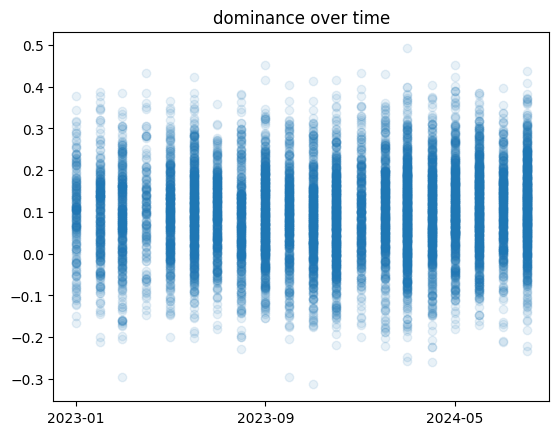

In [ ]:
## Additional plots -- merges migrant data with original dataset to show VAD over time

merged = pd.merge(results, dataset, how="left", on="article_idx")
merged.set_index("article_idx", drop=True, inplace=True)
merged.index.rename(None, inplace=True)
merged.drop(["link", "relevancy"], axis=1, inplace=True)
display(merged.head())

def make_scatter(var1, var2):
    plt.scatter(merged[var2], merged[var1], alpha=0.1)
    plt.title("{} over {}".format(var1, var2))
    utilities.adjust_xlabel(4, plt)
    plt.show()

for var in VAD.columns:
    make_scatter(var, "time")